In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import seaborn as sns

In [2]:
import os

# Set the environment variable OMP_NUM_THREADS to 1
os.environ["OMP_NUM_THREADS"] = "1"

from sklearn.cluster import KMeans

In [3]:
views_en = pd.read_csv('data/Philo_en.csv')
views_lang = pd.read_csv('data/Philos_lang.csv')

In [18]:
interventions = pd.read_csv('data/interventions.csv')
interventions = interventions.drop(9)
interventions

,lang,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
0,fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
1,da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
2,de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
3,it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
4,nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaN,2020-03-16,2020-05-29
5,no,2020-02-26,2020-02-26,2020-03-13,2020-03-12,2020-03-24,2020-03-11,2020-06-04
6,sr,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02
7,sv,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaN,2020-03-11,2020-06-05
8,ko,2020-01-20,2020-02-20,2020-02-23,NaN,NaN,2020-02-25,2020-04-15
10,fi,2020-01-29,2020-03-21,2020-03-16,2020-03-16,NaN,2020-03-16,2020-05-21


### Preprocessing 

In [4]:
# Rename rows with wrong country code 

views_lang['code'] = views_lang['project'].str.split('.').str[0]
views_en['code'] = views_en['project'].str.split('.').str[0]
views_en['subject'] = views_en['article']

In [5]:
#Filter the code to get topics present in all language 
article_counts = views_lang.groupby('subject')['code'].nunique()
articles_to_keep = article_counts[article_counts == views_lang['code'].nunique()].index.tolist()
views_lang_filtered = views_lang[views_lang['subject'].isin(articles_to_keep)]

In [6]:
def compute_fraction_per_lang(views):
    
    grouped = views.groupby(['code', 'project'])['views'].sum()
    articles = views.groupby(['code','subject'])['views'].sum()

    grouped = grouped.to_frame(name='views_count_by_language').reset_index()
    articles = articles.to_frame(name='views_count_by_article').reset_index()

    merged_df = pd.merge(articles, grouped[['code','views_count_by_language']], on='code', how='left')
    merged_df['fraction_of_views'] = merged_df['views_count_by_article'] / merged_df['views_count_by_language']
    
    return merged_df

In [7]:
def compute_cluster(fraction_views, nb_cluster) : 
    fraction_views_clustered = fraction_views.copy()
    kmeans = KMeans(nb_cluster, n_init= 10)
    kmeans.fit(fraction_views_clustered)
    fraction_views_clustered = kmeans.labels_
    return fraction_views_clustered

In [8]:
def plot_elbow_method(fraction_views, nb_cluster_max) : 
    wcss = []

    # Arr is a matrix of fraction of views per language per article for each country
    arr = np.vstack(fraction_views.groupby('code')['fraction_of_views'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)

    for i in range(1, nb_cluster_max):  # Trying different numbers of clusters from 1 to 10
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init= 10)
        kmeans.fit(arr)
        wcss.append(kmeans.inertia_)  # Inertia is the within-cluster sum of squares

    # Plotting the elbow curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.xticks(np.arange(1, 11, 1))  # Setting x-axis ticks from 1 to 10
    plt.grid()

In [9]:
fraction_views_lang = compute_fraction_per_lang(views_lang_filtered)

In [10]:
views_lang

,project,article,timestamp,views,subject,code
0,fr.wikipedia,Absurde,2019060100,269,Absurdism,fr
1,fr.wikipedia,Absurde,2019060200,311,Absurdism,fr
2,fr.wikipedia,Absurde,2019060300,385,Absurdism,fr
3,fr.wikipedia,Absurde,2019060400,396,Absurdism,fr
4,fr.wikipedia,Absurde,2019060500,407,Absurdism,fr
...,...,...,...,...,...,...
1410655,fi.wikipedia,Zurvalaisuus,2020122800,2,Zurvanism,fi
1410656,fi.wikipedia,Zurvalaisuus,2020122900,3,Zurvanism,fi
1410657,fi.wikipedia,Zurvalaisuus,2020123000,2,Zurvanism,fi
1410658,fi.wikipedia,Zurvalaisuus,2020123100,1,Zurvanism,fi


## Evolution of the consulation of Philosophy page during covid across different countries 

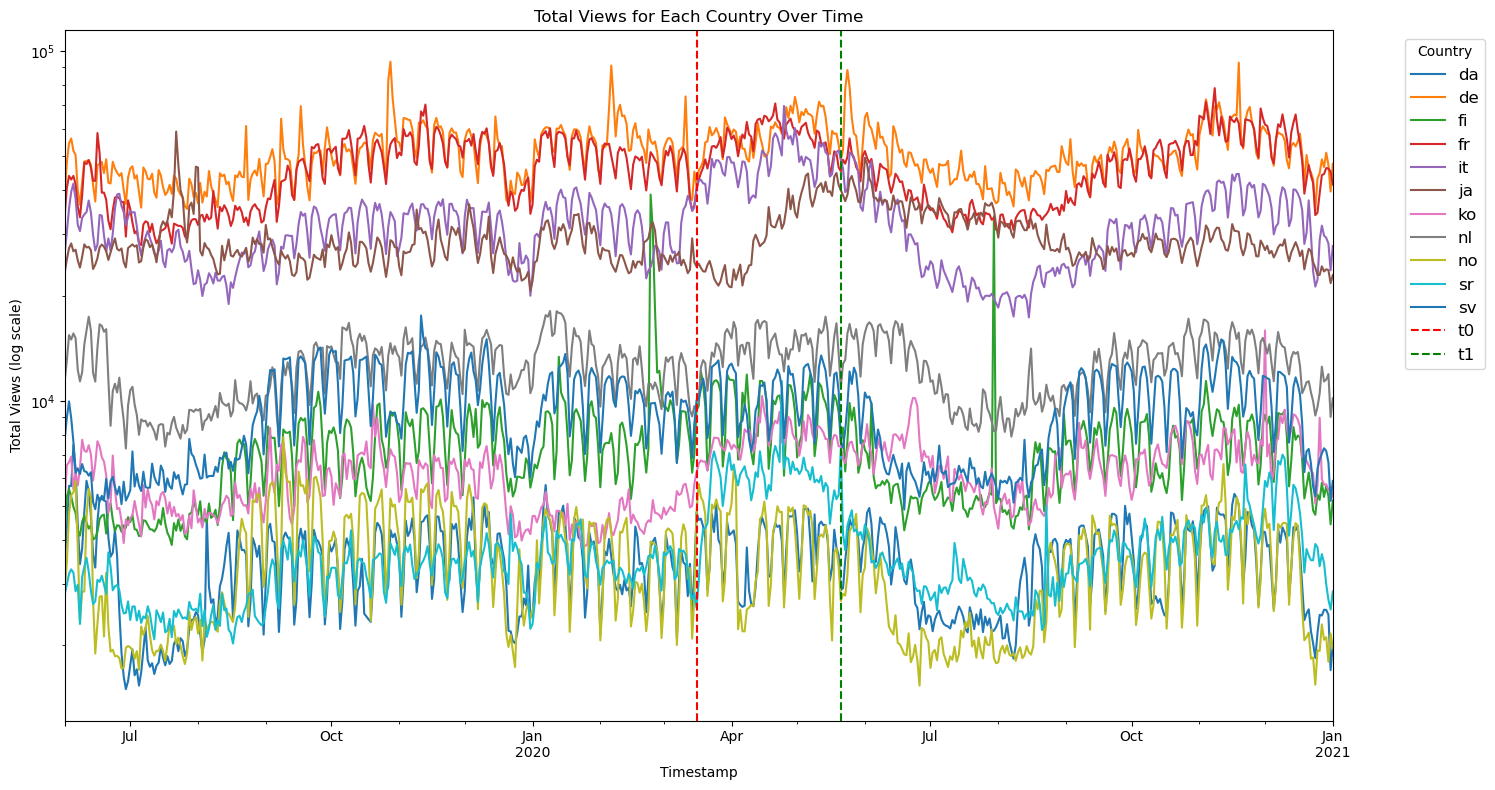

In [24]:
t0 = interventions.iloc[-1,-2]
t1 = interventions.iloc[-1,-1]

df_agg = views_lang.groupby(['timestamp', 'code'])['views'].sum().reset_index()

# Pivot the DataFrame to create a separate column for each country
df_pivot = df_agg.pivot(index='timestamp', columns='code', values='views')


# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 8))

# Plot all countries' time series in log scale
df_pivot.plot(ax=ax, logy=True)

# Add vertical lines for dates t0, t1, t2
plt.axvline(x=t0, color='red', linestyle='--', label='t0')
plt.axvline(x=t1, color='green', linestyle='--', label='t1')

# Set labels and title
ax.set_xlabel('Timestamp')
ax.set_ylabel('Total Views (log scale)')
ax.set_title('Total Views for Each Country Over Time')

# Add legend
ax.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large')

# Show the plot
plt.tight_layout()
plt.show()

In [136]:
interventions_thresholds = interventions.copy(deep=True)

interventions_thresholds['Normalcy'] = pd.to_datetime(interventions_thresholds['Normalcy'])
interventions_thresholds['Mobility'] = pd.to_datetime(interventions_thresholds['Mobility'])
interventions_thresholds['date_difference'] = (interventions_thresholds['Normalcy'] - interventions_thresholds['Mobility']).dt.days

# Compute the mean difference
mean_difference = interventions_thresholds['date_difference'].mean()

# Add the mean difference to the 'Normalcy' column
interventions_thresholds['Windowed_Normalcy'] = interventions_thresholds['Mobility'] + pd.to_timedelta(mean_difference, unit='D')

threshold_date_before = interventions_thresholds[['lang','Mobility']]
threshold_date_after = interventions_thresholds[['lang','Windowed_Normalcy']]

threshold_date_before.set_index('lang', inplace=True)
threshold_date_after.set_index('lang', inplace=True)

threshold_date_before = threshold_date_before.squeeze()
threshold_date_after = threshold_date_after.squeeze()

In [137]:
Total_views = views_lang.groupby(['code','timestamp'])['views'].sum()
Total_views_df = Total_views.reset_index()

codes = views_lang['code'].unique()
before_threshold_all = pd.DataFrame()
between_thresholds_all = pd.DataFrame()
after_threshold_all = pd.DataFrame()

for code in codes : 

    lang_rows = Total_views_df[Total_views_df['code'] == code]

    before_threshold = lang_rows[lang_rows['timestamp'] < threshold_date_before.loc[code]]
    between_thresholds = lang_rows[(lang_rows['timestamp'] >= threshold_date_before.loc[code]) & (lang_rows['timestamp'] <= threshold_date_after.loc[code])]
    after_threshold = lang_rows[lang_rows['timestamp'] > threshold_date_after.loc[code]]

    before_threshold_all = pd.concat([before_threshold_all, before_threshold])
    between_thresholds_all = pd.concat([between_thresholds_all, between_thresholds])
    after_threshold_all = pd.concat([after_threshold_all, after_threshold])

In [228]:
min_lengths = after_threshold_all.groupby('code').size().min()

# Create a new DataFrame to store the modified views
views_lang_after_df = pd.DataFrame()

# Iterate through each country and remove the first n dates
for country, group in after_threshold_all.groupby('code'):
    modified_group = pd.DataFrame()

    # Remove the first n dates to match the minimum length
    modified_group = after_threshold_all[after_threshold_all['code'] == country].iloc[after_threshold_all[after_threshold_all['code'] == country]['views'].size - min_lengths:]
    
    # Append the modified views to the new DataFrame
    views_lang_after_df = pd.concat([views_lang_after_df, modified_group])

# Reset the index of the new DataFrame
views_lang_after_df.reset_index(drop=True, inplace=True)


In [232]:
min_lengths = before_threshold_all.groupby('code').size().min()

# Create a new DataFrame to store the modified views
views_lang_before_df = pd.DataFrame()

# Iterate through each country and remove the first n dates
for country, group in before_threshold_all.groupby('code'):
    modified_group = pd.DataFrame()

    # Remove the first n dates to match the minimum length
    modified_group = before_threshold_all[before_threshold_all['code'] == country].iloc[before_threshold_all[before_threshold_all['code'] == country]['views'].size - min_lengths:]
    
    # Append the modified views to the new DataFrame
    views_lang_before_df = pd.concat([views_lang_before_df, modified_group])

# Reset the index of the new DataFrame
views_lang_before_df.reset_index(drop=True, inplace=True)


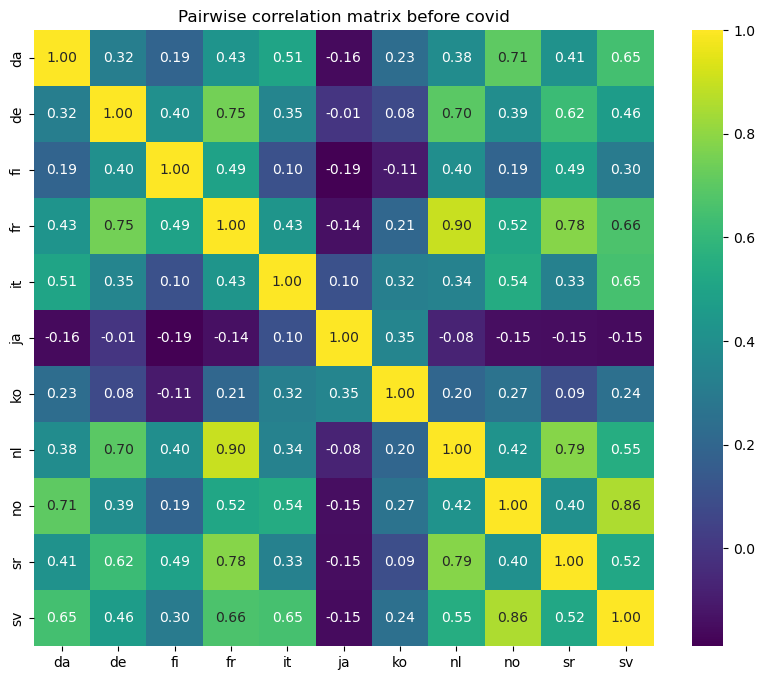

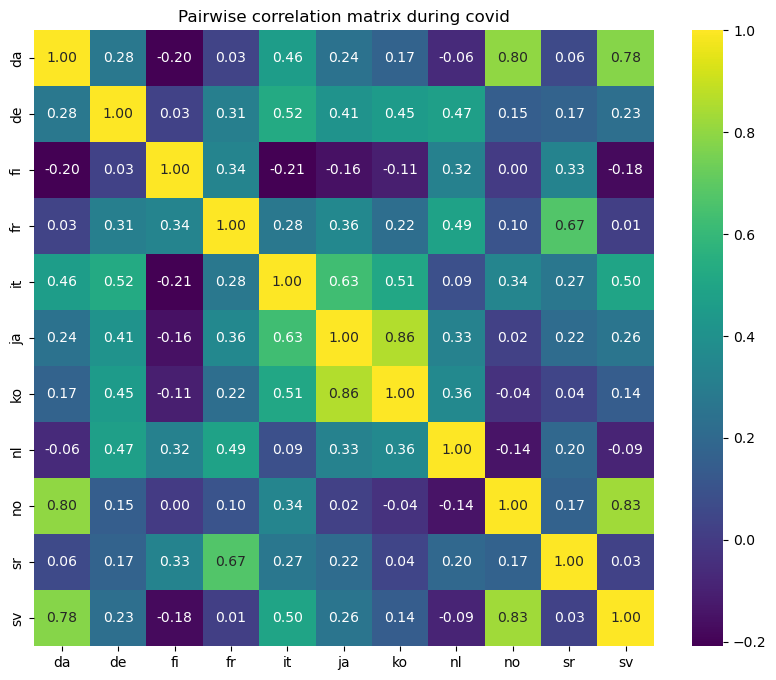

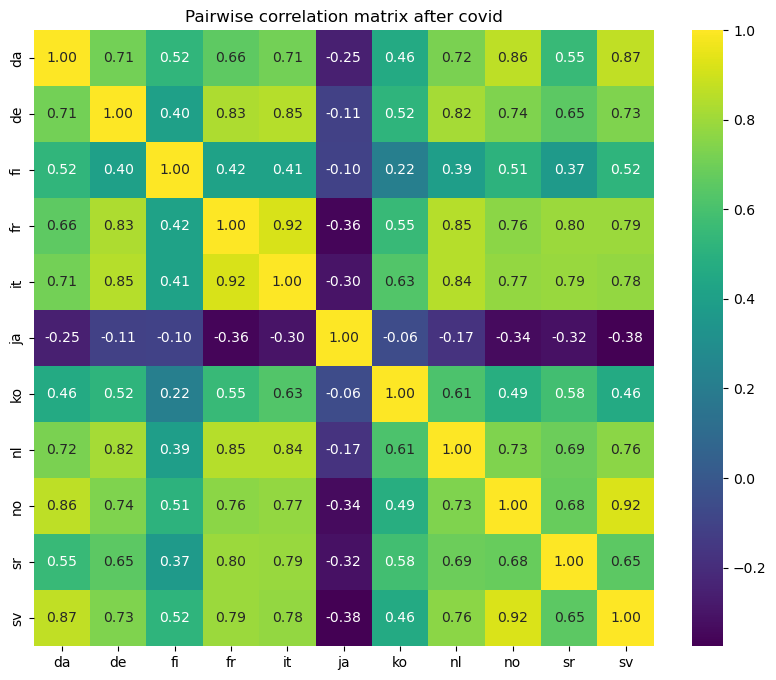

In [239]:
PERPLEXITY = 5

arr_before = np.vstack(views_lang_before_df.groupby('code')['views'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)

correlation_matrix_before = pd.DataFrame(arr_before).T.corr()

arr_between = np.vstack(between_thresholds_all.groupby('code')['views'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)

correlation_matrix_between  = pd.DataFrame(arr_between).T.corr()

arr_after = np.vstack(views_lang_after_df.groupby('code')['views'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)

correlation_matrix_after  = pd.DataFrame(arr_after).T.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_before, cmap='viridis', annot=True, fmt=".2f",
            xticklabels=views_lang_before_df['code'].unique(), yticklabels=views_lang_before_df['code'].unique())
plt.title('Pairwise correlation matrix before covid')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_between, cmap='viridis', annot=True, fmt=".2f",
            xticklabels=views_lang_before_df['code'].unique(), yticklabels=views_lang_before_df['code'].unique())
plt.title('Pairwise correlation matrix during covid')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_after, cmap='viridis', annot=True, fmt=".2f",
            xticklabels=views_lang_before_df['code'].unique(), yticklabels=views_lang_before_df['code'].unique())
plt.title('Pairwise correlation matrix after covid')
plt.show()

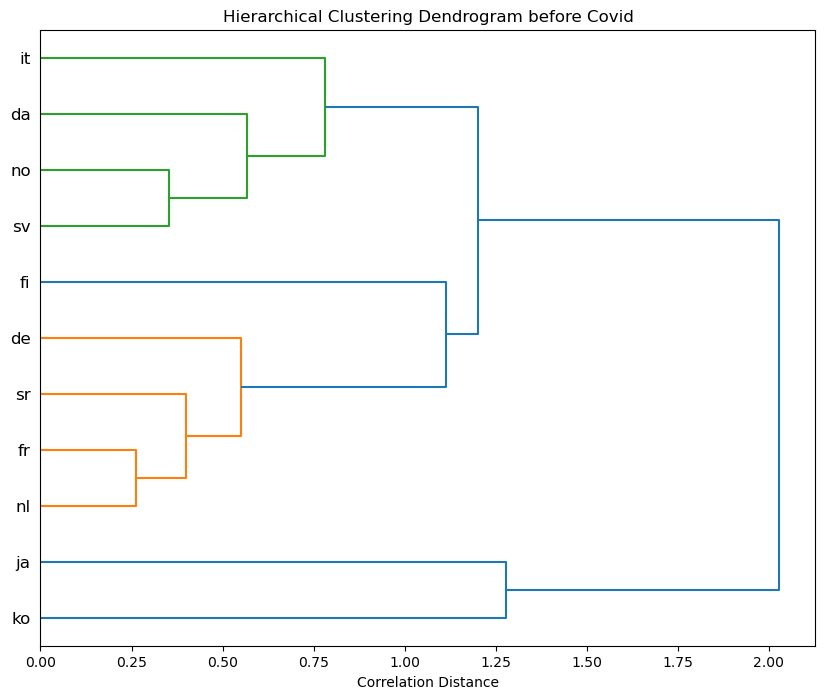

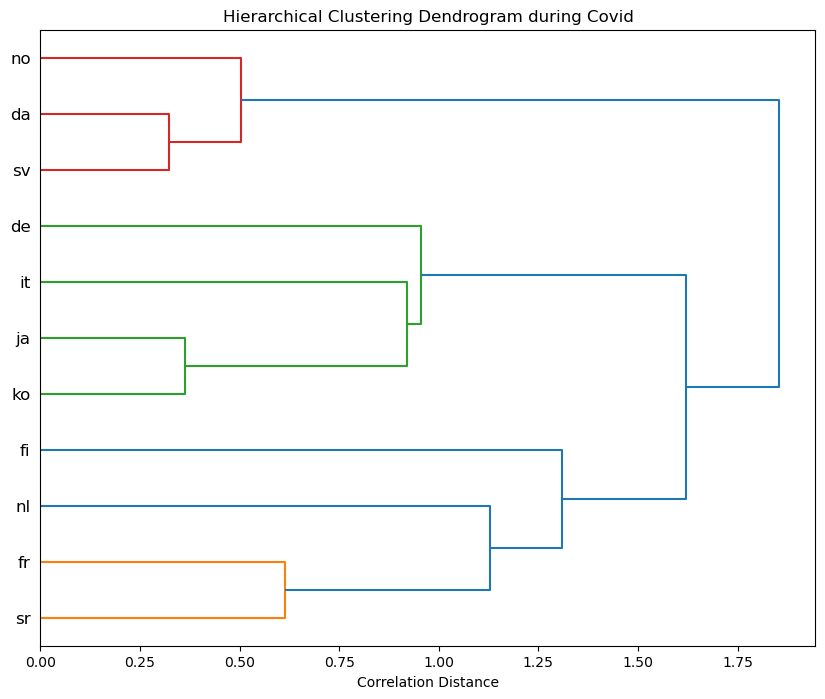

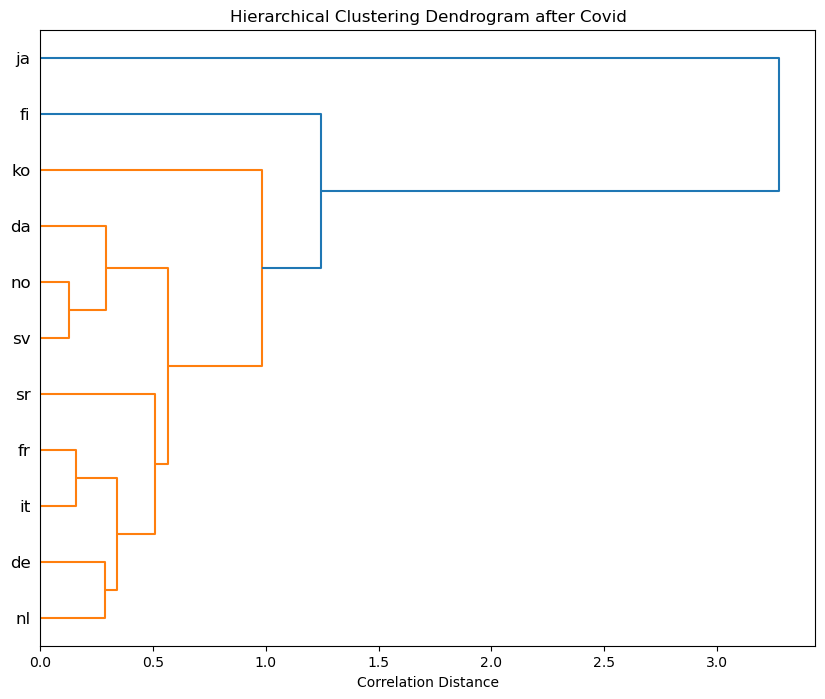

In [261]:
from scipy.cluster.hierarchy import linkage, dendrogram

inkage_matrix_before = linkage(correlation_matrix_before.values, method='average')

inkage_matrix_between = linkage(correlation_matrix_between.values, method='average')

inkage_matrix_after = linkage(correlation_matrix_after.values, method='average')


plt.figure(figsize=(10, 8))
dendrogram(inkage_matrix_before, labels=views_lang['code'].unique(), orientation='right', distance_sort='descending', color_threshold=1.0)
plt.title('Hierarchical Clustering Dendrogram before Covid')
plt.xlabel('Correlation Distance')
plt.show()

plt.figure(figsize=(10, 8))
dendrogram(inkage_matrix_between, labels=views_lang['code'].unique(), orientation='right', distance_sort='descending', color_threshold=1.0)
plt.title('Hierarchical Clustering Dendrogram during Covid')
plt.xlabel('Correlation Distance')
plt.show()


plt.figure(figsize=(10, 8))
dendrogram(inkage_matrix_after, labels=views_lang['code'].unique(), orientation='right', distance_sort='descending', color_threshold=1.0)
plt.title('Hierarchical Clustering Dendrogram after Covid')
plt.xlabel('Correlation Distance')
plt.show()



## Distance between data points 

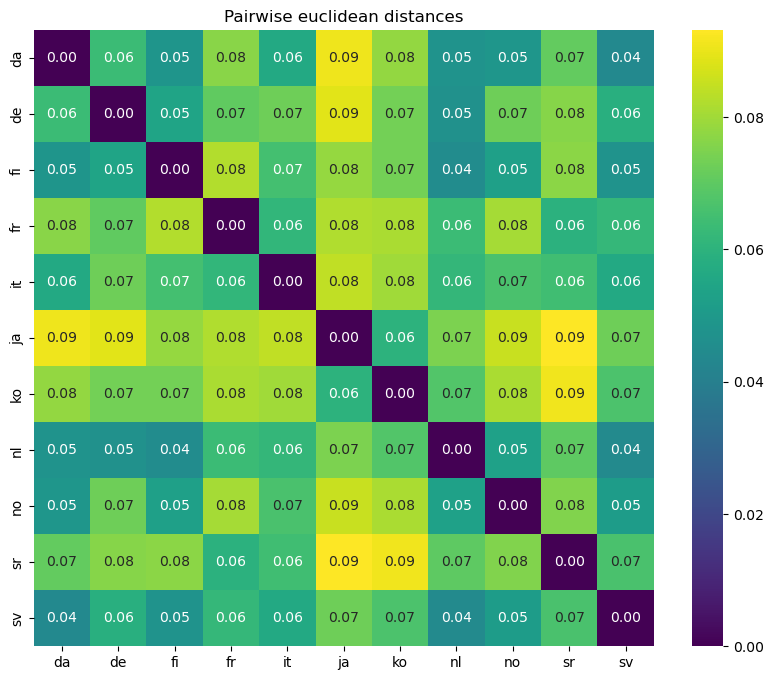

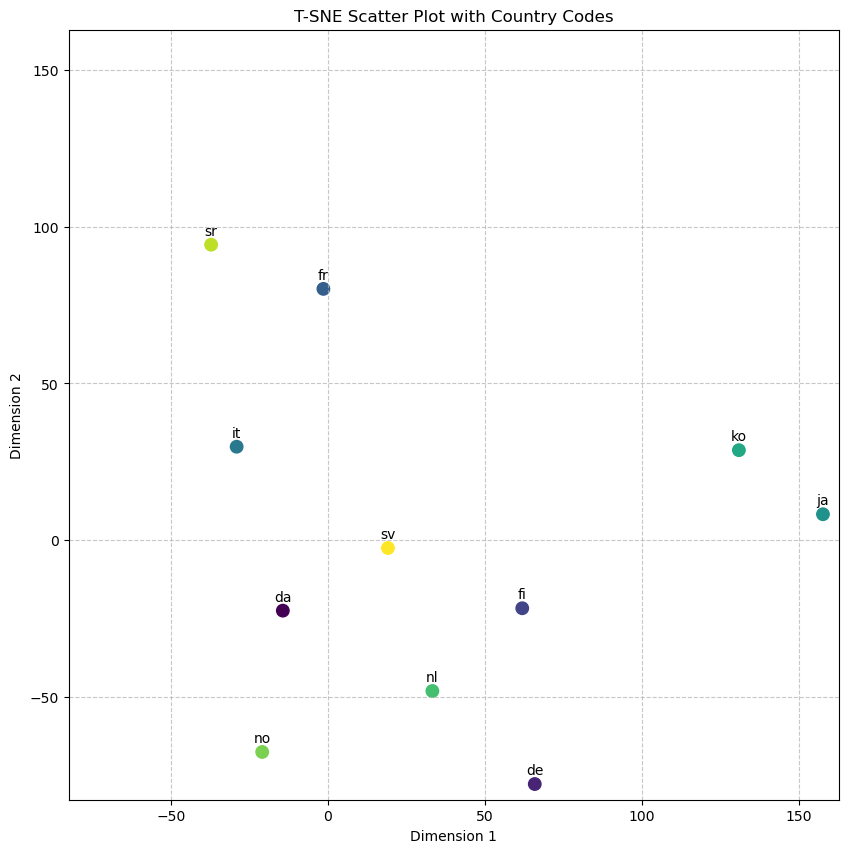

In [47]:
PERPLEXITY = 5

arr = np.vstack(fraction_views_lang.groupby('code')['fraction_of_views'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)

distances = pairwise_distances(arr, metric='euclidean')

# Apply T-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, perplexity=PERPLEXITY, random_state=42)
data_2d = tsne.fit_transform(arr)

# Create a DataFrame for the 2D data
df_2d = pd.DataFrame(data_2d, columns=['Dimension 1', 'Dimension 2'])

df_2d.index = fraction_views_lang['code'].unique()

plt.figure(figsize=(10, 8))
sns.heatmap(distances, cmap='viridis', annot=True, fmt=".2f",
            xticklabels=fraction_views_lang['code'].unique(), yticklabels=fraction_views_lang['code'].unique())
plt.title('Pairwise euclidean distances')
plt.show()

plt.figure(figsize=(10, 10))

# Set a colormap for better visualization
colors = np.arange(len(fraction_views_lang['code'].unique()))

scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=colors, cmap='viridis', s=80)

# Annotate each point with its corresponding country code inside the dot

for code, (x, y) in zip(fraction_views_lang['code'].unique(), data_2d):
    plt.annotate(code, (x, y), textcoords="offset points", xytext=(0, 7), ha='center')


# Set equal aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

# Set the same range of values on both axes
min_val = data_2d.min() - 5
max_val = data_2d.max() + 5
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.title('T-SNE Scatter Plot with Country Codes')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Custering 

c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Window

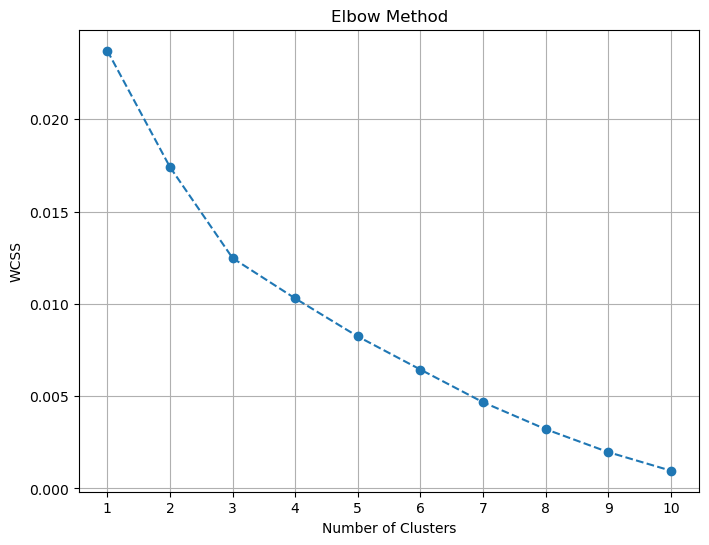

In [48]:
plot_elbow_method(fraction_views_lang, 11)

In [49]:
NB_CLUSTER = 3

arr = np.vstack(fraction_views_lang.groupby('code')['fraction_of_views'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)
clusters = compute_cluster(arr, NB_CLUSTER)
lang_clusters = pd.DataFrame({'Cluster_Labels': clusters, 'Country_Codes': fraction_views_lang['code'].unique()})

for cluster_label, group in lang_clusters.groupby('Cluster_Labels'):
    country_names = ', '.join(group['Country_Codes'])
    print(f'Cluster {cluster_label}: {country_names}')

c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster 0: fr, it, sr
Cluster 1: ja, ko
Cluster 2: da, de, fi, nl, no, sv


## Same but for each period

In [52]:
interventions_thresholds = interventions.copy(deep=True)

threshold_date_before = interventions_thresholds[['lang','Mobility']]
threshold_date_after = interventions_thresholds[['lang','Normalcy']]

threshold_date_before.set_index('lang', inplace=True)
threshold_date_after.set_index('lang', inplace=True)

threshold_date_before = threshold_date_before.squeeze()
threshold_date_after = threshold_date_after.squeeze()

In [53]:
views_lang_copy = views_lang.copy(deep=True)
codes = views_lang_copy['code'].unique()
before_threshold_all = pd.DataFrame()
between_thresholds_all = pd.DataFrame()
after_threshold_all = pd.DataFrame()

for code in codes : 

    lang_rows = views_lang_copy[views_lang_copy['code'] == code]

    before_threshold = lang_rows[lang_rows['timestamp'] < threshold_date_before.loc[code]]
    between_thresholds = lang_rows[(lang_rows['timestamp'] >= threshold_date_before.loc[code]) & (lang_rows['timestamp'] <= threshold_date_after.loc[code])]
    after_threshold = lang_rows[lang_rows['timestamp'] > threshold_date_after.loc[code]]

    before_threshold_all = pd.concat([before_threshold_all, before_threshold])
    between_thresholds_all = pd.concat([between_thresholds_all, between_thresholds])
    after_threshold_all = pd.concat([after_threshold_all, after_threshold])

In [54]:
#Filter the code to get topics present in all language 

article_counts = before_threshold_all.groupby('subject')['code'].nunique()
articles_to_keep = article_counts[article_counts == before_threshold_all['code'].nunique()].index.tolist()
before_threshold_all_filtered = before_threshold_all[before_threshold_all['subject'].isin(articles_to_keep)]

article_counts = between_thresholds_all.groupby('subject')['code'].nunique()
articles_to_keep = article_counts[article_counts == between_thresholds_all['code'].nunique()].index.tolist()
between_thresholds_all_filtered = between_thresholds_all[between_thresholds_all['subject'].isin(articles_to_keep)]

article_counts = after_threshold_all.groupby('subject')['code'].nunique()
articles_to_keep = article_counts[article_counts == after_threshold_all['code'].nunique()].index.tolist()
after_threshold_all_filtered = after_threshold_all[after_threshold_all['subject'].isin(articles_to_keep)]

In [55]:
fraction_views_lang_before = compute_fraction_per_lang(before_threshold_all_filtered)
fraction_views_lang_between = compute_fraction_per_lang(between_thresholds_all_filtered)
fraction_views_lang_after = compute_fraction_per_lang(after_threshold_all_filtered)

### Without subtracting mean (Noisy time series)

c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Window

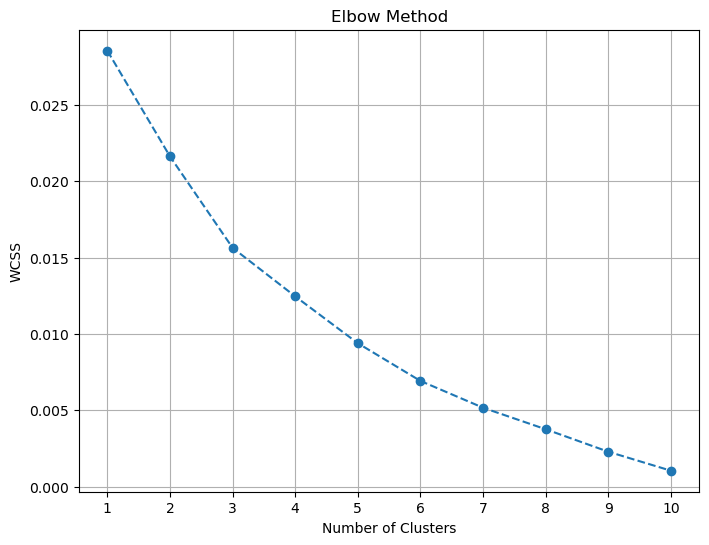

In [56]:
plot_elbow_method(fraction_views_lang_before, 11)

In [57]:
NB_CLUSTER = 3

arr = np.vstack(fraction_views_lang_before.groupby('code')['fraction_of_views'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)
clusters = compute_cluster(arr, NB_CLUSTER)
lang_clusters = pd.DataFrame({'Cluster_Labels': clusters, 'Country_Codes': fraction_views_lang_before['code'].unique()})

for cluster_label, group in lang_clusters.groupby('Cluster_Labels'):
    country_names = ', '.join(group['Country_Codes'])
    print(f'Cluster {cluster_label}: {country_names}')

c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster 0: fr, it, sr
Cluster 1: da, de, fi, nl, no, sv
Cluster 2: ja, ko


c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Window

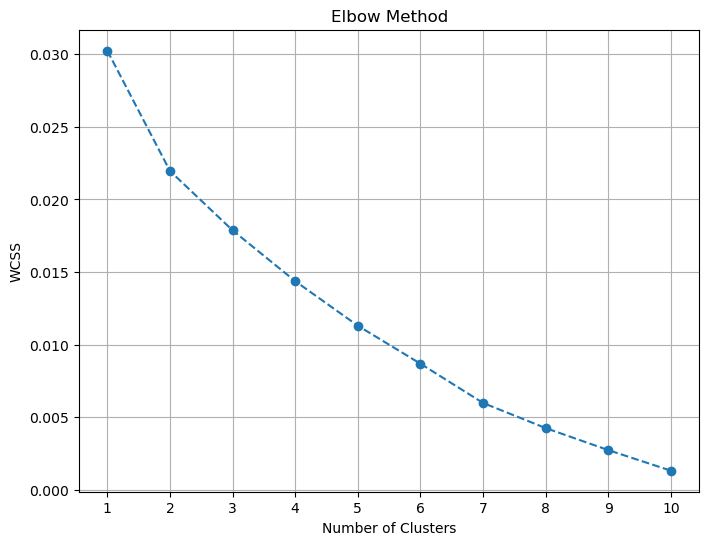

In [58]:
plot_elbow_method(fraction_views_lang_between, 11)

In [59]:
NB_CLUSTER = 2

arr = np.vstack(fraction_views_lang_between.groupby('code')['fraction_of_views'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)
clusters = compute_cluster(arr, NB_CLUSTER)
lang_clusters = pd.DataFrame({'Cluster_Labels': clusters, 'Country_Codes': fraction_views_lang_between['code'].unique()})

for cluster_label, group in lang_clusters.groupby('Cluster_Labels'):
    country_names = ', '.join(group['Country_Codes'])
    print(f'Cluster {cluster_label}: {country_names}')

c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster 0: da, de, fi, fr, it, nl, no, sr, sv
Cluster 1: ja, ko


c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Window

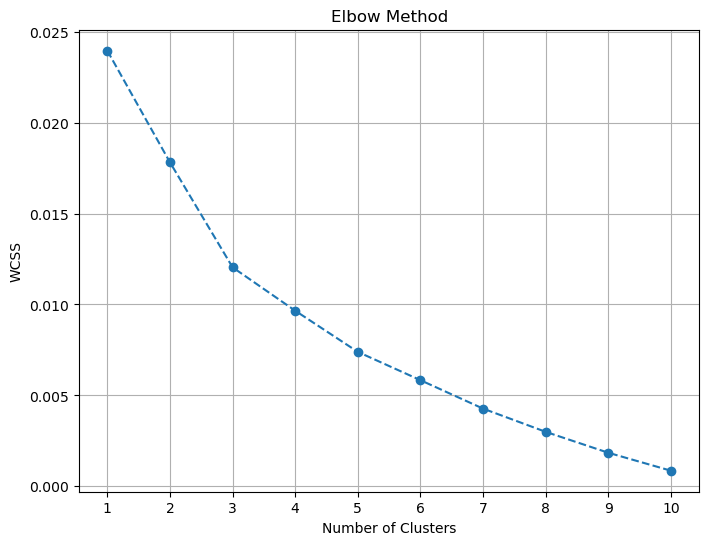

In [60]:
plot_elbow_method(fraction_views_lang_after, 11)

In [61]:
NB_CLUSTER = 3

arr = np.vstack(fraction_views_lang_after.groupby('code')['fraction_of_views'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)
clusters = compute_cluster(arr, NB_CLUSTER)
lang_clusters = pd.DataFrame({'Cluster_Labels': clusters, 'Country_Codes': fraction_views_lang_after['code'].unique()})

for cluster_label, group in lang_clusters.groupby('Cluster_Labels'):
    country_names = ', '.join(group['Country_Codes'])
    print(f'Cluster {cluster_label}: {country_names}')

c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster 0: da, de, fi, nl, no, sv
Cluster 1: ja, ko
Cluster 2: fr, it, sr


### Substracting Mean  (Reducing Noise)

In [62]:
def compute_fraction_per_delta_t(views):
    # Group by 'code', 'project', and 'timestamp' to get views per language per timestamp
    grouped = views.groupby(['code', 'project', 'timestamp'])['views'].sum()

    # Group by 'code', 'subject', and 'timestamp' to get views per article per timestamp
    articles = views.groupby(['code', 'subject', 'timestamp'])['views'].sum()


    grouped = grouped.to_frame(name='views_count_by_language').reset_index()
    articles = articles.to_frame(name='views_count_by_article').reset_index()

    # Merge the two DataFrames on 'code' and 'timestamp'
    #merged_df = pd.merge(articles, grouped[['code', 'timestamp', 'views']], on=['code', 'timestamp'], how='left')

    # Rename the columns
    #merged_df = merged_df.rename(columns={'views_x': 'views_count_by_article', 'views_y': 'views_count_by_language'})

    # Calculate the fraction of views for each date
    #merged_df['fraction_of_views'] = merged_df['views_count_by_article'] / merged_df.groupby(['code', 'timestamp'])['views_count_by_language'].transform('sum')

    merged_df = pd.merge(articles, grouped[['timestamp','code','views_count_by_language']], on=['timestamp', 'code'], how='left')
    merged_df['fraction_of_views'] = merged_df['views_count_by_article'] / merged_df['views_count_by_language']
    
    return merged_df

In [63]:
fraction_views_lang_before_delta_t = compute_fraction_per_delta_t(before_threshold_all_filtered)

In [64]:
mean_fraction_logs = fraction_views_lang_before_delta_t.groupby(['subject', 'code'])['fraction_of_views'].mean().reset_index()
fraction_of_logs_df = pd.merge(fraction_views_lang_before, mean_fraction_logs, on=['subject', 'code'], suffixes=('', '_mean'))

fraction_of_logs_df['adjusted_fraction_of_logs'] = fraction_of_logs_df['fraction_of_views'] - fraction_of_logs_df['fraction_of_views_mean']


c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Window

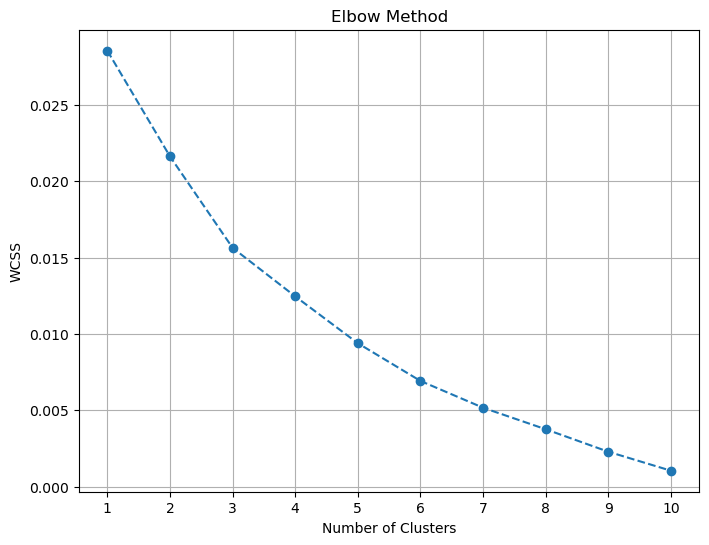

In [65]:
plot_elbow_method(fraction_of_logs_df, 11)

In [66]:
NB_CLUSTER = 3

arr = np.vstack(fraction_of_logs_df.groupby('code')['fraction_of_views'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)
clusters = compute_cluster(arr, NB_CLUSTER)
lang_clusters = pd.DataFrame({'Cluster_Labels': clusters, 'Country_Codes': fraction_of_logs_df['code'].unique()})

for cluster_label, group in lang_clusters.groupby('Cluster_Labels'):
    country_names = ', '.join(group['Country_Codes'])
    print(f'Cluster {cluster_label}: {country_names}')

c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster 0: da, de, fi, nl, no, sv
Cluster 1: fr, it, sr
Cluster 2: ja, ko


In [67]:
mean_fraction_logs = fraction_views_lang_before_delta_t.groupby(['subject', 'code'])['fraction_of_views'].mean().reset_index()
fraction_of_logs_df_between = pd.merge(fraction_views_lang_between, mean_fraction_logs, on=['subject', 'code'], suffixes=('', '_mean'))

fraction_of_logs_df_between['adjusted_fraction_of_logs'] = fraction_of_logs_df_between['fraction_of_views'] - fraction_of_logs_df_between['fraction_of_views_mean']


c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Window

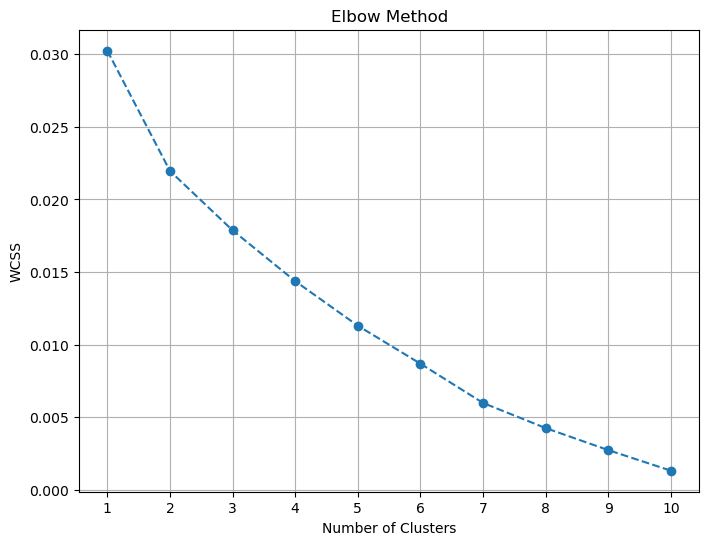

In [68]:
plot_elbow_method(fraction_of_logs_df_between, 11)

In [69]:
NB_CLUSTER = 2

arr = np.vstack(fraction_of_logs_df_between.groupby('code')['fraction_of_views'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)
clusters = compute_cluster(arr, NB_CLUSTER)
lang_clusters = pd.DataFrame({'Cluster_Labels': clusters, 'Country_Codes': fraction_of_logs_df_between['code'].unique()})

for cluster_label, group in lang_clusters.groupby('Cluster_Labels'):
    country_names = ', '.join(group['Country_Codes'])
    print(f'Cluster {cluster_label}: {country_names}')

c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster 0: ja, ko
Cluster 1: da, de, fi, fr, it, nl, no, sr, sv


In [70]:
mean_fraction_logs = fraction_views_lang_before_delta_t.groupby(['subject', 'code'])['fraction_of_views'].mean().reset_index()
fraction_of_logs_df_after = pd.merge(fraction_views_lang_between, mean_fraction_logs, on=['subject', 'code'], suffixes=('', '_mean'))

fraction_of_logs_df_after['adjusted_fraction_of_logs'] = fraction_of_logs_df_after['fraction_of_views'] - fraction_of_logs_df_after['fraction_of_views_mean']


c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Window

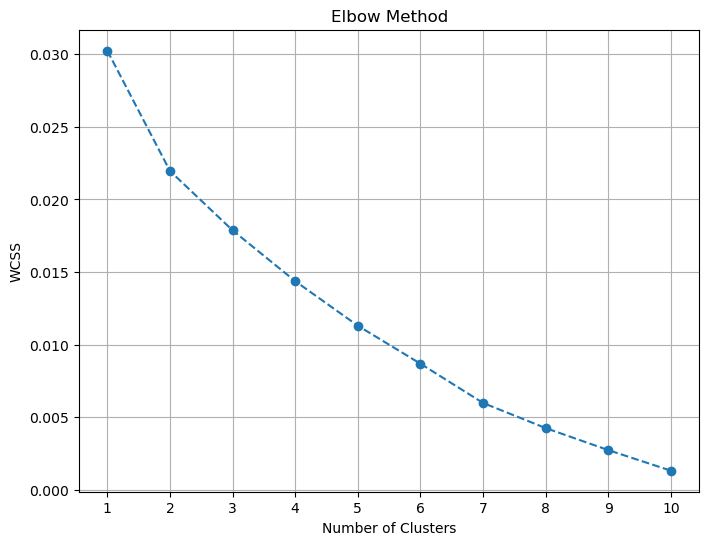

In [71]:
plot_elbow_method(fraction_of_logs_df_after, 11)

In [72]:
NB_CLUSTER = 2

arr = np.vstack(fraction_of_logs_df_after.groupby('code')['fraction_of_views'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)
clusters = compute_cluster(arr, NB_CLUSTER)
lang_clusters = pd.DataFrame({'Cluster_Labels': clusters, 'Country_Codes': fraction_of_logs_df_after['code'].unique()})

for cluster_label, group in lang_clusters.groupby('Cluster_Labels'):
    country_names = ', '.join(group['Country_Codes'])
    print(f'Cluster {cluster_label}: {country_names}')

c:\Users\lapin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster 0: da, de, fi, fr, it, nl, no, sr, sv
Cluster 1: ja, ko


## Analysis of the change in most consulted topics

In [166]:
fraction_views_lang_not_filtered = compute_fraction_per_lang(views_lang)

In [167]:
fraction_views_lang_not_filtered

,code,subject,views_count_by_article,views_count_by_language,fraction_of_views
0,da,Absurdism,9243,6250540,0.001479
1,da,Actual idealism,74176,6250540,0.011867
2,da,Actualism,2960,6250540,0.000474
3,da,Aesthetic Realism,169572,6250540,0.027129
4,da,Aesthetics,80658,6250540,0.012904
...,...,...,...,...,...
2232,sv,Philosophy of motion,15186,17418050,0.000872
2233,sv,Philosophy of music,7440,17418050,0.000427
2234,sv,School of Names,134680,17418050,0.007732
2235,sv,School of Naturalists,46765,17418050,0.002685


In [200]:
grouped = fraction_views_lang_not_filtered.groupby(['subject', 'code'])

# Step 2: Compute the count of unique languages for each page
#page_language_count = grouped.size().reset_index(name='language_count')
article_languages_count = views_lang.groupby('subject')['code'].nunique() 

# Step 3: Filter pages based on the count of unique languages
threshold_unique_languages = 11  # Adjust as needed
filtered_pages = article_languages_count[article_languages_count < threshold_unique_languages]

# Step 4: Apply a threshold filter to select pages with logs above a certain threshold
threshold_log_count = 0.05  # Adjust as needed
final_result = fraction_views_lang_not_filtered[fraction_views_lang_not_filtered['subject'].isin(filtered_pages.index) & (fraction_views_lang_not_filtered['fraction_of_views'] > threshold_log_count)]

final_result

,code,subject,views_count_by_article,views_count_by_language,fraction_of_views
223,de,Continental philosophy,4864971,88900800,0.054724
574,fi,Philosophy of artificial intelligence,743808,14018637,0.053059


In [192]:
article_languages_count = views_lang.groupby('subject')['code'].nunique() 

In [194]:
article_languages_count[article_languages_count > threshold_unique_languages]

subject
Absurdism                   11
Actual idealism              9
Actualism                    8
Advaita Vedanta              8
Aesthetic Realism           10
                            ..
Philosophy of music         10
School of Names             11
School of Naturalists       11
The Philosophy of Chance    11
Western esotericism          7
Name: code, Length: 237, dtype: int64